In [1]:
#jupyter notebook --NotebookApp.max_buffer_size=4096

!pip install fuzzy-c-means
!pip install matplotlib
!pip install sklearn
!pip install scikit-learn-extra
!pip install graphviz

  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=2cf2b34c48267a05328906a935a8e61e79cb25051ccbef20444f55067696eeeb
  Stored in directory: c:\users\acer\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [2]:
from os import path

import numpy as np
import pandas as pd
from fcmeans import FCM
from matplotlib import pyplot as plt
from sklearn.cluster import (
    DBSCAN,
    AgglomerativeClustering,
    Birch,
    KMeans,
    SpectralClustering,
)
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids

from multicons import MultiCons
from multicons.utils import jaccard_similarity

np.set_printoptions(threshold=100)

In [4]:
studentInfo_df = pd.read_csv('studentInfo.csv')
studentInfo_df.info()
studentInfo_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [5]:
# Remove duplicate values
studentProfile_df = studentInfo_df[['id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band']].drop_duplicates()
studentProfile_df.info()
studentProfile_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28857 entries, 0 to 32592
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id_student         28857 non-null  int64 
 1   gender             28857 non-null  object
 2   region             28857 non-null  object
 3   highest_education  28857 non-null  object
 4   imd_band           27877 non-null  object
 5   age_band           28857 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


,id_student,gender,region,highest_education,imd_band,age_band
0,11391,M,East Anglian Region,HE Qualification,90-100%,55<=
1,28400,F,Scotland,HE Qualification,20-30%,35-55
2,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55
3,31604,F,South East Region,A Level or Equivalent,50-60%,35-55
4,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35


In [5]:
enc_studentProfile_df = pd.get_dummies(studentProfile_df, columns=["gender"])
enc_studentProfile_df.head()

,id_student,region,highest_education,imd_band,age_band,gender_F,gender_M
0,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,1
1,28400,Scotland,HE Qualification,20-30%,35-55,1,0
2,30268,North Western Region,A Level or Equivalent,30-40%,35-55,1,0
3,31604,South East Region,A Level or Equivalent,50-60%,35-55,1,0
4,32885,West Midlands Region,Lower Than A Level,50-60%,0-35,1,0


In [6]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

enc_studentProfile_df['imd_band'] = label_encoder.fit_transform(enc_studentProfile_df['imd_band']) 
enc_studentProfile_df['region'] = label_encoder.fit_transform(enc_studentProfile_df['region']) 
enc_studentProfile_df['highest_education'] = label_encoder.fit_transform(enc_studentProfile_df['highest_education']) 
enc_studentProfile_df['age_band'] = label_encoder.fit_transform(enc_studentProfile_df['age_band']) 

enc_studentProfile_df.drop(['id_student'], axis = 1, inplace = True)

enc_studentProfile_df.head()

,region,highest_education,imd_band,age_band,gender_F,gender_M
0,0,1,9,2,0,1
1,6,1,2,1,1,0
2,5,0,3,1,1,0
3,7,0,5,1,1,0
4,11,2,5,0,1,0


In [7]:
enc_studentProfile_df.drop(['imd_band', 'age_band', 'gender_F', 'gender_M'], axis = 1, inplace=True)
enc_studentProfile_df.shape

(28857, 2)

In [8]:
enc_studentProfile_df = enc_studentProfile_df.sample(frac=0.10)
enc_studentProfile_df.shape

(2886, 2)

In [9]:
# Our collection of base clusterings
base_clusterings = []

# K-means O(N.K.L) N: #samples; K: #clusters; L: #iterations
base_clusterings.append(KMeans(n_clusters=3).fit_predict(enc_studentProfile_df))

'''
# Average linkage O(N^3)
base_clusterings.append(
    AgglomerativeClustering(n_clusters=3).fit_predict(enc_studentProfile_df)
)
'''

# Gaussian model O(N.K.D^3) D: #data dimensions
base_clusterings.append(
    GaussianMixture(n_components=3, random_state=5).fit_predict(enc_studentProfile_df)
)

# C-means O(N.K)
fcm = FCM(n_clusters=3, max_iter=5, m=5)
fcm.fit(enc_studentProfile_df.values)
base_clusterings.append(fcm.predict(enc_studentProfile_df.values))

'''
# PAM O(N^2)
base_clusterings.append(KMedoids(n_clusters=3).fit_predict(enc_studentProfile_df))
'''

# BIRCH O(N)
birch = Birch(n_clusters=3, threshold=0.5)
base_clusterings.append(birch.fit_predict(enc_studentProfile_df))

'''
# Spectral O(N^3)
base_clusterings.append(
    SpectralClustering(n_clusters=3).fit_predict(enc_studentProfile_df)
)
'''

'''
# DBSCAN O(NlogN)
base_clusterings.append(DBSCAN(eps=0.2).fit_predict(enc_studentProfile_df))
'''

'\n# DBSCAN O(NlogN)\nbase_clusterings.append(DBSCAN(eps=0.2).fit_predict(enc_studentProfile_df))\n'

In [10]:
np.array(base_clusterings)

array([[1, 1, 0, ..., 1, 2, 0],
       [1, 1, 2, ..., 1, 0, 2],
       [2, 2, 0, ..., 2, 1, 0],
       [0, 0, 1, ..., 0, 2, 1]])

In [11]:
# MultiCons implementation aims to follow scikit-learn conventions.
consensus = MultiCons().fit(base_clusterings)
consensus

MultiCons(consensus_function=<function consensus_function_10 at 0x7fba155d11f0>,
          similarity_measure=<function jaccard_similarity at 0x7fba1560bdc0>)

In [12]:
# The `consensus_vectors` attribute is a python list containing the
# consensus candidates.
# We transform it to a numpy array to better visualize it here.
np.array(consensus.consensus_vectors)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 1],
       [8, 8, 7, ..., 8, 6, 7]])

In [13]:
# The `decision_thresholds` attribute contains a list of decision thresholds
# for each consensus vector.
consensus.decision_thresholds

[2, 3, 4]

In [14]:
# The `recommended` attribute contains the index of the recommended consensus
# vector
consensus.recommended

1

In [15]:
# The `labels_` attribute contains the recommended consensus vector
consensus.labels_

array([0, 0, 1, ..., 0, 1, 1])

In [16]:
# The `stability` attribute contains a list of stability values
# for each consensus vector.
consensus.stability

[2, 1, 1]

In [17]:
# The `tree_quality` member contains a measure of the tree quality.
# The measure ranges between 0 and 1. Higher is better.
consensus.tree_quality

0.75

In [18]:
# The `ensemble_similarity` contains a list of ensemble similarity measures
# for each consensus vector.
# They are between 0 and 1. Higher is better.
consensus.ensemble_similarity

array([0.35595945, 0.54666966, 0.52683423])

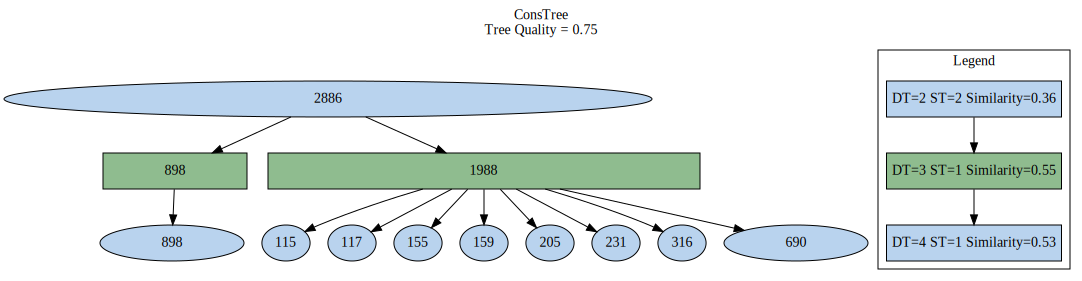

In [23]:
# %% [markdown]
# **Finally, let's visualize the consenus candidates using the ConsTree method:**

# %%
cons_tree = consensus.cons_tree()
cons_tree

In [25]:
# %%
# Save the ConsTree graph to a file
cons_tree.render(outfile=f"./StudentInfoConsTree.svg", cleanup=True)

'StudentInfoConsTree.svg'